# Synonymous vs non-synonymous internal exon-centered analysis

The aim of this notebook is to test for differences within the internal exon-analysis between synonymous and non-synonymous mutations on two independent analysis.

---

## Output

The output of the notebook is multiple intermediate files containing numbers of observed and expected mutations and several plots.

In [3]:
%matplotlib inline

from os import path
import math
import pybedtools
import tabix  # package pytabix
from bgreference import hg19
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.ticker as plticker
import gzip, pickle

from python_scripts.plot_functions import config_plot_params
config_plot_params()

## Input files

Files in **data** directory.

- *middle_exons_coords*: file with the coordinates of the middle exons
- *consequence_type_file*: tabix file with the consequence types of exonic mutations
- *consequence_ranking_file*: file with information about the ensembl hierarchy in predicted functional consequences

Files in **results** directory.

- *signatures.txt*: file with the mutational signatures computed from genome-wide mutation datasets, for a 3-mer model.

### Other inputs

- mutations_folder: base directory where the files with the mutations are located
- tumor_type: germinal in our case

In [4]:
# Path to data
middle_exons_coords = 'data/coordinates/genes_middle_exon_coords.bed.gz'
consequence_type_file = 'data/consequence/consequence_ranking.tsv.bgz'
consequence_ranking_file = 'data/consequence/consequence_ranking_info.tsv'

# Other
mutations_folder = 'non_provided_data/mutations/'
tumor_type = 'germinal'

## Functions

All the functions needed for this notebook are coded below

In [5]:
def remove_version_ensembl(x, colname):
    """
    Remove version from the ensembl ID

    Args:
        x: dataframe row
        colname: column name

    Returns:
        str. Text before a '.'

    """
    ensembl_id = x[colname]
    ensembl_id_only = ensembl_id.split('.')[0]

    return ensembl_id_only

In [6]:
def synonymous_or_not(x):
    """
    Classifies consequence types between synonymous and non synonymous
    using the RANK column

    Args:
        x: dataframe row

    Returns:
        str. *synonymous* or *non_synonymous*

    """

    my_rank = x['RANK']

    if my_rank < 15:
        my_consequence = 'non_synonymous'

    else:
        my_consequence = 'synonymous'

    return my_consequence

In [7]:
# This function was made for testing purposes:
def check_consequence_TEST(chromosome, start_coord, alt, tabix):
    """
    Function that classifies a given exonic mutation into the VEP classification given
    tabix file with predicted effect.

    Args:
        chromosome: chromosome coordinate
        start_coord: coordinate of the mutation
        alt: alternative nucleotide
        tabix: tabix indexed file containing the information
        rank_info: dictionary with all the types of predicted effect and if we classify them as synonymous or not.
    Returns:
        str. Class of mutation on VEP classification

    """
    
    my_chr = chromosome[3:]
    effects = tabix.querys("{}:{}-{}".format(my_chr, start_coord, start_coord))
    for effect in effects:
        if len(effect) < 6:
            continue
        if effect[3] == alt:
            consequence = effect[5].rstrip('\r')
            return(consequence)

In [8]:
def check_consequence(chromosome, start_coord, alt, tabix, rank_info):
    """
    Function that classifies a given exonic mutation into synonymous 
    or not given a rank info and a tabix file with predicted effect.

    Args:
        chromosome: chromosome coordinate
        start_coord: coordinate of the mutation
        alt: alternative nucleotide
        tabix: tabix indexed file containing the predicted VEP classification effect for a given position and change.
        rank_info: dictionary with all the types of predicted effect and if we classify them as synonymous or not.
    Returns:
        str. *synonymous* or *non_synonymous*

    """
    
    my_chr = chromosome[3:]
    effects = tabix.querys("{}:{}-{}".format(my_chr, start_coord, start_coord))
    for effect in effects:
        if len(effect) < 6:
            continue
        if effect[3] == alt:
            consequence = effect[5].rstrip('\r')
            try:
                con = rank_info[consequence]
                return(con)
            except:
                return('None')

In [9]:
# This function was made for testing purposes:
def countX(lst, x): 
    count = 0
    for ele in lst: 
        if (ele == x): 
            count = count + 1
    return count

In [10]:
def remove_muts(mut_data, IDs_list):
    """
    Function that removes mutations from a data frame, only if the mutation matches and ID
    and it is enclosed in the exon coordinates of the specific 2001-nt window.

    Args:
        mut_data: dataframe with columns "range_chr range_start range_end ensembl region_size
                    region_middle_start region_middle_end exon_start exon_end mut_chr mut_start
                    mut_end mut_ref mut_alt mut_sample mut_type mut_ID overlap_bp
        IDs_list: list of IDs that must be removed
    Returns:
        pandas data frame with mutations with the ID removed, they sould be removed only once if the IDs are repeated.

    """
    rows_to_remove = []
    for ID in IDs_list:
        sub_frame = mut_data[mut_data['mut_ID'] == ID]
        for index, row in sub_frame.iterrows():
            if (row['exon_start'] <= row['mut_end'] and row['exon_end'] >= row['mut_end']):
                rows_to_remove.append(index)
    return(mut_data.drop(rows_to_remove))

In [11]:
def compute_intron_probs(sequence, signatures_dict, rel_start, middle_distance_threshold, tumor_type):
    """
    Function that computes the summed probabilities of the three posible trinucleotide changes for each trinucleotide
    in a given intronic sequence of a middle exon-centered window.
    
    Args:
        sequence: intronic sequence. It should contain one extra nucleotide on each side to compute all the
        trinucleotides.
        signatures_dict: Dictionary containing probabilities of each trinucleotide change.
        rel_start: Relative start of that sequence within the middle exon-centered window.
        middle_distance_threshold: middle distance of the exon-centered window.
        tumor_type: First type of class to find the specific mutation signature class.
        cluster_id: Second type of class to find the specific mutation signature class.
      
    Returns:
        list containing subslists with paired normalized position within the middle exon-centered window and
        associated probability.

    """
    
    nucleotides = set(['A', 'T', 'C', 'G'])
    position_prob = []
    
    ## Divide intronic sequences into trinucleotides
    my_trinucleotides = [sequence[i:i+3] for i in range(len(sequence)-2)]
    
    #Foreach trinucleotide
    for my_trinucleotide in my_trinucleotides:
        #Get the reference
        my_ref_base = my_trinucleotide[1].upper()
        #The rest are alternative ones
        my_alt_bases = nucleotides - set(my_ref_base)
        my_base_probs = 0
        #Get previous and next base
        previous_base = my_trinucleotide[0]
        next_base = my_trinucleotide[2]
        
        #Foreach alternative, each of the three possible changes given a nucleotide.
        for alt_base in my_alt_bases:
            #Built reference and alternative trinucleotide
            tri_ref = previous_base + str(my_ref_base) + next_base
            tri_alt = previous_base + str(alt_base) + next_base
            #Create key for the signatue dictionary.
            my_key = str((tri_ref, tri_alt))

            try:
                #Get the probability
                my_prob = signatures_dict[my_key]['Probability_' + tumor_type]
                #Sum the probability of the three possible changes.
                my_base_probs = my_base_probs + my_prob
            except:
                None
            
        ### Add the position in the 2001-nt window with the correspondent probability in a list
        normalized_pos = rel_start - middle_distance_threshold
        my_row = [normalized_pos, my_base_probs]
        position_prob.append(my_row)
        rel_start += 1
        
    return(position_prob)

In [12]:
def compute_exon_probs(chromosome, abs_start, sequence, signatures_dict, rel_start, middle_distance_threshold,
                       tumor_type, rank_info, tabix, include):
    """
    Function that computes the summed probabilities of the three posible trinucleotide changes for each trinucleotide
    in a given exonic sequence of a middle exon-centered window.
    
    Args:
        chromosome: chromosome where the sequence is located in hg19 genome.
        abs_start: absolute start of the exonic sequence in hg19 coordinates.
        sequence: exonic sequence. It should contain one extra nucleotide on each side to compute all the trinucleotides.
        signatures_dict: Dictionary containing probabilities of each trinucleotide change.
        rel_start: Relative start of that sequence within the middle exon-centered window.
        middle_distance_threshold: middle distance of the exon-centered window.
        tumor_type: First type of class to find the specific mutation signature class.
        cluster_id: Second type of class to find the specific mutation signature class.
        rank_info: dictionary containing the rank classification (syn or non-syn) of an specific VEP class.
        tabix: tabix indexed file containing the predicted VEP classification effect for a given position and change.
        inlcude(str): *synonymous* or *non_syonymous* . Which type od change consider to add probabilities.
      
    Returns:
        list containing subslists with paired normalized position within the middle exon-centered window and associated
        probability.

    """
    position_prob = []
    my_chr = chromosome[3:]

    ## Divide intronic sequences into trinucleotides
    my_trinucleotides = [sequence[i:i+3] for i in range(len(sequence)-2)]
    
    #Foreach trinucleotide
    for my_trinucleotide in my_trinucleotides:
        #Get the reference
        my_ref_base = my_trinucleotide[1].upper()
        my_base_probs = 0
        #Get previous and next base
        previous_base = my_trinucleotide[0]
        next_base = my_trinucleotide[2]
        effects = tabix.querys("{}:{}-{}".format(my_chr, abs_start + 1, abs_start + 1))
        for effect in effects:
            if len(effect) < 6:
                print('At chromosome ' + str(my_chr) + ' position ' + str(abs_start + 1) + ' no effect is reported.')
                continue
            consequence = effect[5].rstrip('\r')
            try:
                synonymous_or_not = rank_info[consequence]
                if synonymous_or_not == include:
                    #Built reference and alternative trinucleotide
                    tri_ref = previous_base + str(my_ref_base) + next_base
                    tri_alt = previous_base + str(effect[3]) + next_base
                    #Create key for the signatue dictionary.
                    my_key = str((tri_ref, tri_alt))
                    try:
                        #Get the probability
                        my_prob = signatures_dict[my_key]['Probability_' + tumor_type]
                        #Sum the probability of the three possible changes.
                        my_base_probs = my_base_probs + my_prob
                    except:
                        None
            except:
                None
        
        ### Add the position in the 2001-nt window with the correspondent probability in a list
        normalized_pos = rel_start - middle_distance_threshold
        my_row = [normalized_pos, my_base_probs]
        position_prob.append(my_row)
        abs_start += 1
        rel_start += 1
    
    return(position_prob)

In [13]:
def obs_exp_muts_excluding(mutations_df, exons_coords_df, signatures_dict, tumor_type, middle_distance_threshold,
                           include, tb_consequence_type, consequence_rank_dict):
    """
    Get positions of the exons that correspond to the central position and a number of base pair
    equal to middle_distance_threshold on each side. Compute the number of mutations per position under analysis.
    For each of the relative positions, compute the sum of the probabilities of each possible alteration
    taking into account its context (using the values of the signatures_file) wheighted by the number of observed 
    mutations (MODIFIED FROM FRIGOLA ET AL.).
    You can exclude synonymous or non-synonymous mutations by specifying it.
    
    Args:
        mutations_df:
        exons_coords_symbol_df:
        signatures_dict:
        tumor_type:
        cluster_id: 
        middle_distance_threshold:
        include:
        tb_consequence_type:
        consequence_rank_dict: 

    Returns:
        :class:`~pandas.DataFrame`. Table with the relative position (to the exon center)
        the number of mutations observed and expected in that position.

    """
    
    # Convert mutations into bed to intersect values
    mutations_bed = pybedtools.BedTool.from_dataframe(mutations_df)

    # Convert exonic coordinates into bed to intersect values
    exon_coords_bed = pybedtools.BedTool.from_dataframe(exons_coords_df)

    # Process exonic coordinates to get the 2001-nt region coords and convert into bed
    ## Positions that correspond to the center of the exons
    exons_coords_symbol_df['exon_size'] = (exons_coords_symbol_df['end'] - exons_coords_symbol_df['start'])
    exons_coords_symbol_df['exon_middle_start'] = (exons_coords_symbol_df['start'] + exons_coords_symbol_df['exon_size']/2)
    exons_coords_symbol_df['exon_middle_start'] = exons_coords_symbol_df.apply(lambda x:
                                                                       math.floor(x['exon_middle_start']), axis=1)
    
    ## Positions around the middle point
    exons_coords_symbol_df['exon_middle_end'] = exons_coords_symbol_df['exon_middle_start'] + 1
    exons_coords_symbol_df['region_start'] = exons_coords_symbol_df['exon_middle_start'] - middle_distance_threshold
    exons_coords_symbol_df['region_end'] = exons_coords_symbol_df['exon_middle_end'] + middle_distance_threshold
    region_coords = exons_coords_symbol_df[['chr', 'region_start', 'region_end', 'ensembl',
                                          'exon_size', 'exon_middle_start', 'exon_middle_end', 'start', 'end']]
    region_coords_bed = pybedtools.BedTool.from_dataframe(region_coords)

    # Filter mutations by the full region of interest
    my_bed = region_coords_bed.intersect(mutations_bed, wao=True)

    mutations_in_range = pd.read_table(my_bed.fn, names = ['range_chr', 'range_start', 'range_end',
                        'ensembl','region_size', 'region_middle_start', 'region_middle_end',
                        'exon_start', 'exon_end', 'mut_chr', 'mut_start', 'mut_end', 'mut_ref', 'mut_alt',
                        'mut_sample', 'mut_type', 'mut_ID', 'overlap_bp'],  sep="\s+", index_col=False)
    mutations_in_range = mutations_in_range[mutations_in_range['overlap_bp'] != 0]
    print("The total amount of mutations at the middle exon-centered sequences is " + str(len(mutations_in_range.index)))

    # Filter mutations by the exonic regions
    my_bed2 = exon_coords_bed.intersect(mutations_bed, wao=True)
    mutations_in_range2 = pd.read_table(my_bed2.fn, names = ['exon_chr', 'exon_start', 'exon_end',
                        'ensembl', 'mut_chr', 'mut_start', 'mut_end', 'mut_ref', 'mut_alt',
                        'mut_sample', 'mut_type', 'mut_ID', 'overlap_bp'],  sep="\s+", index_col=False)
    mutations_in_range2 = mutations_in_range2[mutations_in_range2['overlap_bp'] != 0]
    mutations_in_range2 = mutations_in_range2[['mut_chr', 'mut_start', 'mut_end', 'mut_ref', 
                        'mut_alt', 'mut_sample', 'mut_type', 'mut_ID']]
    mutations_in_range2.columns = ['chr', 'start', 'end', 'ref', 'alt', 'sample', 'type', 'ID']
    print("The total amount of mutations at the exonic sequences are " + str(len(mutations_in_range2.index)))

    #Find the amount of mutations that fall in each VEP category (TESTING PURPOSES)

    mutations_in_range2['category'] = mutations_in_range2.apply(lambda x: 
                           check_consequence_TEST(x['chr'], x['end'], x['alt'], tb_consequence_type),
                           axis=1)
    all_elements = mutations_in_range2['category'].tolist()
    unique_elements = set(all_elements)
    for n in unique_elements:
        count = countX(all_elements, n)
        print ("The category " + str(n) + " is found " + str(count) + " times.")

    # Find if mutations at exonic regions are synonymous or not.
    mutations_in_range2['conseq'] = mutations_in_range2.apply(lambda x: 
                       check_consequence(x['chr'], x['end'], x['alt'], tb_consequence_type, consequence_rank_dict),
                       axis=1)
    
    # Check the number of mutations that were not classified (they would not be included,
    # but is important to know the amount of drops):

    #mutations_in_range2[(mutations_in_range2['conseq'] != 'synonymous')
    #& (mutations_in_range2['conseq'] != 'non_synonymous')]

    # Find the amount of mutations that fall in both synonymous and non-synonymous categories.
    # Additionally, check the number of mutations that were not classified (they would not be included,
    # but is important to know the amount of drops):
    #all_elements = mutations_in_range2['conseq'].tolist()
    #unique_elements = set(all_elements)
    #for n in unique_elements:
    #    count = countX(all_elements, n)
    #    print ("The category " + str(n) + " is found " + str(count) + " times.")


    # Get the index of exonic non synonymous mutations and mutations without category 
    # to remove them from the mutation dataset at the 2001-nt sequences
    muts_to_drop = mutations_in_range2[mutations_in_range2['conseq'] != include]
    IDs_to_drop = muts_to_drop['ID'].tolist()
    mutations_in_range = remove_muts(mutations_in_range, IDs_to_drop)

    # Count observed mutations
    ## Create a dictionary of all observed positions at the range of the middle exon-centered window
    mutations_in_range['relative_start'] = mutations_in_range['mut_start'] - mutations_in_range['region_middle_start']
    exon_counts = mutations_in_range['relative_start'].value_counts().to_dict()

    ## Set count to 0 were no mutation has been found
    for i in range(-middle_distance_threshold,middle_distance_threshold):
        if i not in exon_counts.keys():
            exon_counts[i] = 0
    
    ## Count mutations for every position with reported counts
    my_exon_results_lol = list()
    for my_position in exon_counts.keys():
        my_count = exon_counts[my_position]
        my_exon_results_lol.append([my_position, my_count])

    my_exon_results_df = pd.DataFrame(my_exon_results_lol)
    my_exon_results_df.columns = ['position', 'muts_count']
    my_exon_results_df = my_exon_results_df.sort_values(by='position')

    # Compute expected mutations
    ## For each exonic region under analysis get its relative position to the center of the exon
    ## and add the probability that is the sum of the probabilities of the changes
    final_position_prob_df = pd.DataFrame()
    for my_row in region_coords.values.tolist(): ###For each middle exon-centered sequence:
        position_prob_lol = list()
        
        ## Get coordinates
        my_chr = my_row[0]
        my_start = int(my_row[1])
        my_start_exon = int(my_row[7])
        my_end = int(my_row[2])
        my_end_exon = int(my_row[8])
        my_exon_size = int(my_row[4])
        n_bases_fullregion = my_end - my_start
        n_bases_first_flank = my_start_exon - my_start
        n_bases_second_flank = my_end - my_end_exon
        
        ## Delimit mutations in the range of that specific middle exon-centered sequence
        my_region_muts = len(mutations_in_range[(mutations_in_range['range_start'] >= my_start) &
                               (mutations_in_range['range_end'] <= my_end) &
                               (mutations_in_range['range_chr'] == my_chr)])
        
        ## If no mutations are reported for that specific middle exon-centered sequence, skip to the next one.
        if my_region_muts == 0:
            continue
        ## If mutations are reported, get the exonic sequence and the two intronic flanking sequences:
        if my_start_exon <= my_start:
            my_exon_region = hg19(my_chr, my_start, size=n_bases_fullregion + 2)
            position_prob_lol = compute_exon_probs(my_chr, my_start, my_exon_region, signatures_dict, 0,
                                    middle_distance_threshold, tumor_type, consequence_rank_dict,
                                    tb_consequence_type, include)

        else:
            first_flank_region = hg19(my_chr, my_start, size=n_bases_first_flank + 2)
            first_flank_region_list = compute_intron_probs(first_flank_region, signatures_dict, 0, 
                                    middle_distance_threshold, tumor_type)
            
            second_flank_region = hg19(my_chr, my_end_exon, size=n_bases_second_flank + 2)
            second_flank_region_list = compute_intron_probs(second_flank_region, signatures_dict,
                                    n_bases_first_flank + my_exon_size, middle_distance_threshold, tumor_type)
            
            my_exon_region = hg19(my_chr, my_start_exon, size=my_exon_size + 2)
            exon_region_list = compute_exon_probs(my_chr, my_start_exon, my_exon_region, signatures_dict,
                                    n_bases_first_flank, middle_distance_threshold, tumor_type, consequence_rank_dict,
                                    tb_consequence_type, include)
            
            position_prob_lol = first_flank_region_list + exon_region_list + second_flank_region_list
    
        ## Convert the list to a dataframe
        position_prob_df = pd.DataFrame(position_prob_lol)
        position_prob_df.columns = ['position', 'probability']
        
        ## Reescaling probabilities to one
        my_total = sum(position_prob_df['probability'])
        position_prob_df['probability'] = position_prob_df['probability']/my_total
        
        ## Compute the expected by redistributing mutations acoording to probabilities
        position_prob_df['expected_muts'] = position_prob_df['probability']*my_region_muts
        position_prob_df = position_prob_df[['position', 'expected_muts']]
        
        # Sum the expected results
        if len(final_position_prob_df) == 0:
            final_position_prob_df = position_prob_df
        else:
            final_position_prob_df['expected_muts'] = (final_position_prob_df['expected_muts'] +
                                                       position_prob_df['expected_muts'])


    return pd.merge(my_exon_results_df, final_position_prob_df, on='position')

In [14]:
def bin_average(count, size):
    averaged = []
    for i in range(0,len(count),size):
        mean = np.mean(count[i:i+size])
        averaged.extend([mean for i in range(len(count[i:i+size]))])
    return(pd.Series(averaged))

In [15]:
def plot_HD(cluster, ax, cnt):
    
    # read observed and backgruond data directly
    filename = "results/exons_centered_%s.tsv" % (cluster)
    
    if path.isfile(filename):
    
        data = pd.read_csv(filename, sep="\t")
    
        coefs = poly.polyfit(data['position'], data['muts_count'], 50)
        ffit = poly.polyval(data['position'], coefs)

        ax.plot(data['position'],
                 data['muts_count'], '#e41a1c', alpha=0.5, linewidth=0.7)
        ax.plot(data['position'], ffit, '#e41a1c', linewidth=1)

        coefs2 = poly.polyfit(data['position'], data['expected_muts'], 50)
        ffit2 = poly.polyval(data['position'], coefs2)
        ax.plot(data['position'], ffit2, 'black', linewidth=1, ls="--")

        ax.set_axis_bgcolor('none')

        # show the left spline
        for axis in ['right', 'top']:
            ax.spines[axis].set_visible(False)

        # add gap between x- and y-axis
        for axis in ['bottom', 'left']:
            ax.spines[axis].set_position(('axes', -0.03))

        ax.yaxis.major.locator.set_params(nbins=4)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xlim(-1000, 1000)
        # add axis label
        if cnt in [0, 3]:
            ax.set_ylabel('Number of mutations')
        if cnt >=3:
            ax.set_xlabel('Distance from exon center (bp)')

In [16]:
def plot_HD_BINNED(cluster, ax, cnt, size):
    
    # read observed and backgruond data directly
    filename = "results/exons_centered_%s.tsv" % (cluster)
    
    if path.isfile(filename):
    
        data = pd.read_csv(filename, sep="\t")
        
        bin_obs = bin_average(data['muts_count'], size)

        ax.plot(data['position'],
                 data['muts_count'], '#e41a1c', alpha=0.5, linewidth=0.7)
        ax.plot(data['position'], bin_obs, '#e41a1c', linewidth=1)

        bin_exp = bin_average(data['expected_muts'], size)

        ax.plot(data['position'], bin_exp, 'black', linewidth=1)

        ax.set_axis_bgcolor('none')

        # show the left spline
        for axis in ['right', 'top']:
            ax.spines[axis].set_visible(False)

        # add gap between x- and y-axis
        for axis in ['bottom', 'left']:
            ax.spines[axis].set_position(('axes', -0.03))

        ax.yaxis.major.locator.set_params(nbins=4)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xlim(-1000, 1000)
        # add axis label
        if cnt in [0, 3]:
            ax.set_ylabel('Number of mutations')
        
        ax.set_xlabel('Distance from exon center (bp)')
            
        ax.set_ylim(0, 50)
    
        commonFontsize = 10
        plt.rcParams['font.family'] = ['sans-serif']
        plt.rcParams['font.sans-serif'] = ['arial']
        plt.rcParams['font.size'] = commonFontsize
        plt.rcParams['axes.labelsize'] = commonFontsize
        plt.rcParams['xtick.labelsize'] = commonFontsize
        plt.rcParams['ytick.labelsize'] = commonFontsize
        plt.rcParams['svg.fonttype'] = 'none'
        plt.rcParams['mathtext.fontset'] = 'custom'
        plt.rcParams['mathtext.cal'] = 'arial'
        plt.rcParams['mathtext.rm'] = 'arial'
        plt.rcParams['axes.edgecolor'] = 'black'
        plt.rcParams['ytick.color'] = 'black'
        plt.rcParams['axes.linewidth'] = 1
        plt.rcParams['xtick.major.width'] = 1
        plt.rcParams['ytick.major.width'] = 1
        plt.rcParams['xtick.major.size' ] = 5
        plt.rcParams['ytick.major.size' ] = 5
        ax.set_aspect(aspect = 42)

## Load data

In [15]:
## Get exon coordinates
exons_coords_df = pd.read_csv(middle_exons_coords, sep="\t", header=None, low_memory=False)
exons_coords_df.columns = ['chr', 'start', 'end', 'ensembl', 'symbol', 'strand']
exons_coords_df = exons_coords_df[['chr', 'start', 'end', 'ensembl']]
exons_coords_df['ensembl'] = exons_coords_df.apply(lambda x: remove_version_ensembl(x, 'ensembl'), axis=1)
exons_coords_df.columns = ['chr', 'start', 'end', 'ensembl']
exons_coords_symbol_df = exons_coords_df[['chr', 'start', 'end', 'ensembl']]

## Get mutations
mutations_file = mutations_folder + 'germinal_ultimate_dataset.bed.gz'
mutations_df = pd.read_csv(mutations_file, sep="\t", header=None)
mutations_df.columns = ['chr', 'start', 'end', 'ref', 'alt', 'sample', 'type', 'class']
mutations_df = mutations_df[['chr', 'start', 'end', 'ref', 'alt', 'sample', 'type']]
mutations_df = mutations_df[mutations_df['type'] == 'subs']
mutations_df['ID'] = mutations_df.index + 1

## Get signatures
signatures_file = 'results/3mer_signatures_DNM_new.txt'
all_signatures = pd.read_csv(signatures_file, sep='\t')
probability_name = 'Probability_' + tumor_type
sub_signatures_df = all_signatures[['mutation', probability_name]]
signatures_dict = sub_signatures_df.set_index('mutation').T.to_dict()

## Get consequence tabix file
tb_consequence_type = tabix.open(consequence_type_file)

## Get the consequence rank info and classify separate syn from other types of non-syn (missense, non-sense,...)
consequence_rank_info = pd.read_csv(consequence_ranking_file, delimiter='\t')
consequence_rank_info['TYPE'] = consequence_rank_info.apply(lambda x:synonymous_or_not(x) ,1)
consequence_rank_info = consequence_rank_info[['CONSEQUENCE', 'TYPE']]
consequence_rank_dict = dict(zip(consequence_rank_info['CONSEQUENCE'], consequence_rank_info['TYPE']))

## Middle-Exon centered analysis, synonymous profile

Mutation probabilities were computed genome-wide using the full dataset of germline mutations. Observed and expected values were computed with the method described in the **Exon-centered and intron-centered mutational analyses** section at Frigola et al. However, we do not consider non-synonymous mutations at the exonic positions for the observed and the expected sum of probabilities.

In [16]:
middle_distance_threshold = 1000

include = 'synonymous'

exons_centered_results = obs_exp_muts_excluding(mutations_df, exons_coords_df, signatures_dict, tumor_type, 
                            middle_distance_threshold, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv(path.join('results', "exons_centered_SYNONYMOUS.tsv"), sep="\t", header=True,
                            index=False)

The total amount of mutations at the middle exon-centered sequences is 50780
The total amount of mutations at the exonic sequences are 4757
The category splice_region_variant is found 58 times.
The category splice_donor_variant is found 3 times.
The category None is found 10 times.
The category 5 is found 2 times.
The category splice_acceptor_variant is found 1 times.
The category intron_variant is found 1 times.
The category missense_variant is found 3280 times.
The category upstream_gene_variant is found 8 times.
The category stop_gained is found 202 times.
The category synonymous_variant is found 1184 times.
The category downstream_gene_variant is found 2 times.
The category initiator_codon_variant is found 6 times.


## Middle-Exon centered analysis, non-synonymous profile

Mutation probabilities were computed genome-wide using the full dataset of germline mutations. Observed and expected values were computed with the method described in the **Exon-centered and intron-centered mutational analyses** section at Frigola et al. However, we do not consider synonymous mutations at the exonic positions for the observed and the expected sum of probabilities.

In [17]:
middle_distance_threshold = 1000

include = 'non_synonymous'

exons_centered_results = obs_exp_muts_excluding(mutations_df, exons_coords_df, signatures_dict, tumor_type,
                            middle_distance_threshold, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv(path.join('results', "exons_centered_NON_SYNONYMOUS.tsv"), sep="\t", header=True,
                            index=False)

The total amount of mutations at the middle exon-centered sequences is 50780
The total amount of mutations at the exonic sequences are 4757
The category splice_region_variant is found 58 times.
The category splice_donor_variant is found 3 times.
The category None is found 10 times.
The category 5 is found 2 times.
The category splice_acceptor_variant is found 1 times.
The category intron_variant is found 1 times.
The category missense_variant is found 3280 times.
The category upstream_gene_variant is found 8 times.
The category stop_gained is found 202 times.
The category synonymous_variant is found 1184 times.
The category downstream_gene_variant is found 2 times.
The category initiator_codon_variant is found 6 times.


### Plot results

Polynomial fit approach.

/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


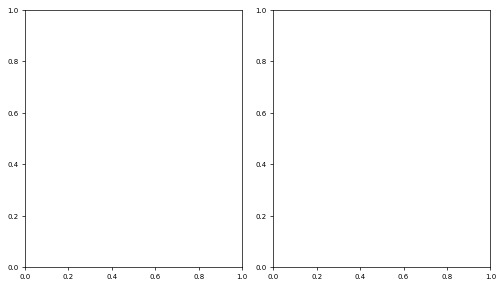

In [19]:
listt = ['SYNONYMOUS', 'NON_SYNONYMOUS']    

NROW=1
NCOL=2

axs = []

fig = plt.figure(figsize=(7,4))

for row in range(0, NROW):
    for col in range(0, NCOL):
        axs.append(plt.subplot2grid((NROW, NCOL), (row, col)))

cnt=0
for ele in listt:
    plot_HD(ele, axs[cnt], cnt)
    cnt+=1
    
    
plt.tight_layout()
plt.savefig(path.join('figures', 'selection_test.svg'), bbox_inches='tight')
plt.show()

### Plot results

Binned average approach. Bin size is 25.

/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


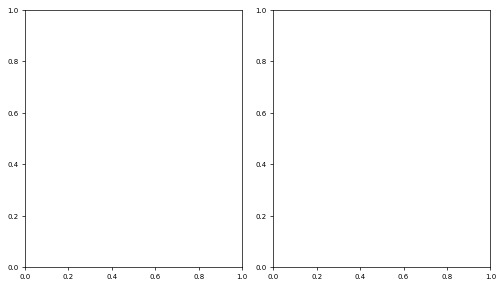

In [18]:
size = 25

listt = ['SYNONYMOUS', 'NON_SYNONYMOUS']     

NROW=1
NCOL=2

axs = []

fig = plt.figure(figsize=(7,4))

for row in range(0, NROW):
    for col in range(0, NCOL):
        axs.append(plt.subplot2grid((NROW, NCOL), (row, col)))

cnt=0
for ele in listt:
    plot_HD_BINNED(ele, axs[cnt], cnt, size)
    cnt+=1
    
    
plt.tight_layout()
plt.savefig(path.join('figures', 'selection_test_BINNED_SYN.svg'), bbox_inches='tight')
plt.show()

# Resample, healthy and ASD

## Load resample data

In [20]:
## Get mutations
mutations_file = mutations_folder + 'germinal_sample.bed.gz'
mutations_df = pd.read_csv(mutations_file, sep="\t", header=None)
mutations_df.columns = ['chr', 'start', 'end', 'ref', 'alt', 'sample', 'type', 'class', 'ID']
mutations_df = mutations_df[['chr', 'start', 'end', 'ref', 'alt', 'sample', 'type', 'ID']]
mutations_df = mutations_df[mutations_df['type'] == 'subs']

signatures_file = 'results/3mer_signatures_sample.txt'

## Get signatures
all_signatures = pd.read_csv(signatures_file, sep='\t')
probability_name = 'Probability_' + tumor_type
sub_signatures_df = all_signatures[['mutation', probability_name]]
signatures_dict = sub_signatures_df.set_index('mutation').T.to_dict()

## Get consequence tabix file
tb_consequence_type = tabix.open(consequence_type_file)

## Get the consequence rank info and classify separate syn from other types of non-syn (missense, non-sense,...)
consequence_rank_info = pd.read_csv(consequence_ranking_file, delimiter='\t')
consequence_rank_info['TYPE'] = consequence_rank_info.apply(lambda x:synonymous_or_not(x) ,1)
consequence_rank_info = consequence_rank_info[['CONSEQUENCE', 'TYPE']]
consequence_rank_dict = dict(zip(consequence_rank_info['CONSEQUENCE'], consequence_rank_info['TYPE']))

## Middle-Exon centered analysis, synonymous profile

Mutation probabilities were computed genome-wide using the full dataset of germline mutations. Observed and expected values were computed with the method described in the **Exon-centered and intron-centered mutational analyses** section at Frigola et al. However, we do not consider non-synonymous mutations at the exonic positions for the observed and the expected sum of probabilities.

In [21]:
middle_distance_threshold = 1000

include = 'synonymous'

exons_centered_results = obs_exp_muts_excluding(mutations_df, exons_coords_df, signatures_dict, tumor_type, 
                            middle_distance_threshold, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv(path.join('results', "exons_centered_SYNONYMOUS_sample.tsv"), sep="\t", header=True,
                            index=False)

The total amount of mutations at the middle exon-centered sequences is 15010
The total amount of mutations at the exonic sequences are 1333
The category splice_region_variant is found 8 times.
The category missense_variant is found 904 times.
The category upstream_gene_variant is found 3 times.
The category stop_gained is found 56 times.
The category synonymous_variant is found 359 times.
The category initiator_codon_variant is found 3 times.


## Middle-Exon centered analysis, non-synonymous profile

Mutation probabilities were computed genome-wide using the full dataset of germline mutations. Observed and expected values were computed with the method described in the **Exon-centered and intron-centered mutational analyses** section at Frigola et al. However, we do not consider synonymous mutations at the exonic positions for the observed and the expected sum of probabilities.

In [22]:
middle_distance_threshold = 1000

include = 'non_synonymous'

exons_centered_results = obs_exp_muts_excluding(mutations_df, exons_coords_df, signatures_dict, tumor_type,
                            middle_distance_threshold, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv(path.join('results', "exons_centered_NON_SYNONYMOUS_sample.tsv"), sep="\t", header=True,
                            index=False)

The total amount of mutations at the middle exon-centered sequences is 15010
The total amount of mutations at the exonic sequences are 1333
The category splice_region_variant is found 8 times.
The category missense_variant is found 904 times.
The category upstream_gene_variant is found 3 times.
The category stop_gained is found 56 times.
The category synonymous_variant is found 359 times.
The category initiator_codon_variant is found 3 times.


### Plot results

Polynomial fit approach.

/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: The fit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:17: RankWarning: The fit may be poorly conditioned
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


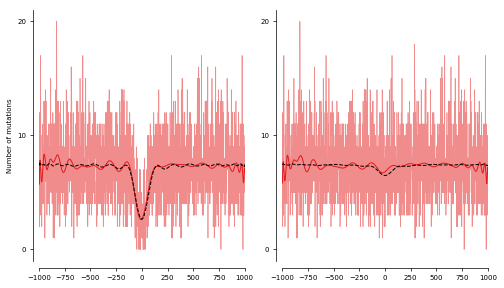

In [23]:
listt = ['SYNONYMOUS_sample', 'NON_SYNONYMOUS_sample']    

NROW=1
NCOL=2

axs = []

fig = plt.figure(figsize=(7,4))

for row in range(0, NROW):
    for col in range(0, NCOL):
        axs.append(plt.subplot2grid((NROW, NCOL), (row, col)))

cnt=0
for ele in listt:
    plot_HD(ele, axs[cnt], cnt)
    cnt+=1
    
    
plt.tight_layout()
plt.savefig(path.join('figures', 'selection_test_sample.svg'), bbox_inches='tight')
plt.show()

### Plot results

Binned average approach. Bin size is 25.

/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


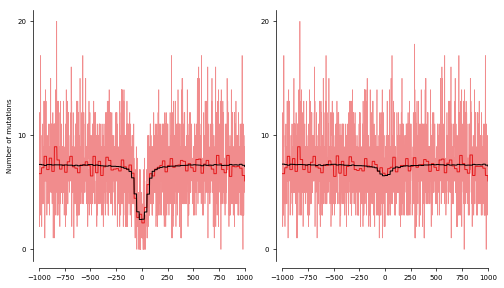

In [24]:
size = 25

listt = ['SYNONYMOUS_sample', 'NON_SYNONYMOUS_sample']    

NROW=1
NCOL=2

axs = []

fig = plt.figure(figsize=(7,4))

for row in range(0, NROW):
    for col in range(0, NCOL):
        axs.append(plt.subplot2grid((NROW, NCOL), (row, col)))

cnt=0
for ele in listt:
    plot_HD_BINNED(ele, axs[cnt], cnt, size)
    cnt+=1
    
    
plt.tight_layout()
plt.savefig(path.join('figures', 'selection_test_BINNED_sample.svg'), bbox_inches='tight')
plt.show()

## Load healthy data

In [25]:
## Get mutations
mutations_file = mutations_folder + 'germinal_healthy.bed.gz'
mutations_df = pd.read_csv(mutations_file, sep="\t", header=None)
mutations_df.columns = ['chr', 'start', 'end', 'ref', 'alt', 'sample', 'type', 'class', 'ID']
mutations_df = mutations_df[['chr', 'start', 'end', 'ref', 'alt', 'sample', 'type', 'ID']]
mutations_df = mutations_df[mutations_df['type'] == 'subs']

signatures_file = 'results/3mer_signatures_healthy.txt'

## Get signatures
all_signatures = pd.read_csv(signatures_file, sep='\t')
probability_name = 'Probability_' + tumor_type
sub_signatures_df = all_signatures[['mutation', probability_name]]
signatures_dict = sub_signatures_df.set_index('mutation').T.to_dict()

## Get consequence tabix file
tb_consequence_type = tabix.open(consequence_type_file)

## Get the consequence rank info and classify separate syn from other types of non-syn (missense, non-sense,...)
consequence_rank_info = pd.read_csv(consequence_ranking_file, delimiter='\t')
consequence_rank_info['TYPE'] = consequence_rank_info.apply(lambda x:synonymous_or_not(x) ,1)
consequence_rank_info = consequence_rank_info[['CONSEQUENCE', 'TYPE']]
consequence_rank_dict = dict(zip(consequence_rank_info['CONSEQUENCE'], consequence_rank_info['TYPE']))

## Middle-Exon centered analysis, synonymous profile

Mutation probabilities were computed genome-wide using the full dataset of germline mutations. Observed and expected values were computed with the method described in the **Exon-centered and intron-centered mutational analyses** section at Frigola et al. However, we do not consider non-synonymous mutations at the exonic positions for the observed and the expected sum of probabilities.

In [26]:
middle_distance_threshold = 1000

include = 'synonymous'

exons_centered_results = obs_exp_muts_excluding(mutations_df, exons_coords_df, signatures_dict, tumor_type, 
                            middle_distance_threshold, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv(path.join('results', "exons_centered_SYNONYMOUS_healthy.tsv"), sep="\t", header=True,
                            index=False)

The total amount of mutations at the middle exon-centered sequences is 17146
The total amount of mutations at the exonic sequences are 1520
The category splice_region_variant is found 13 times.
The category missense_variant is found 1038 times.
The category upstream_gene_variant is found 4 times.
The category stop_gained is found 55 times.
The category synonymous_variant is found 407 times.
The category initiator_codon_variant is found 3 times.


## Middle-Exon centered analysis, non-synonymous profile

Mutation probabilities were computed genome-wide using the full dataset of germline mutations. Observed and expected values were computed with the method described in the **Exon-centered and intron-centered mutational analyses** section at Frigola et al. However, we do not consider synonymous mutations at the exonic positions for the observed and the expected sum of probabilities.

In [27]:
middle_distance_threshold = 1000

include = 'non_synonymous'

exons_centered_results = obs_exp_muts_excluding(mutations_df, exons_coords_df, signatures_dict, tumor_type,
                            middle_distance_threshold, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv(path.join('results', "exons_centered_NON_SYNONYMOUS_healthy.tsv"), sep="\t", header=True,
                            index=False)

The total amount of mutations at the middle exon-centered sequences is 17146
The total amount of mutations at the exonic sequences are 1520
The category splice_region_variant is found 13 times.
The category missense_variant is found 1038 times.
The category upstream_gene_variant is found 4 times.
The category stop_gained is found 55 times.
The category synonymous_variant is found 407 times.
The category initiator_codon_variant is found 3 times.


### Plot results

Polynomial fit approach.

/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: The fit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:17: RankWarning: The fit may be poorly conditioned
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


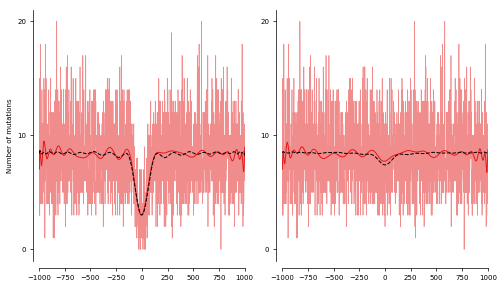

In [28]:
listt = ['SYNONYMOUS_healthy', 'NON_SYNONYMOUS_healthy']    

NROW=1
NCOL=2

axs = []

fig = plt.figure(figsize=(7,4))

for row in range(0, NROW):
    for col in range(0, NCOL):
        axs.append(plt.subplot2grid((NROW, NCOL), (row, col)))

cnt=0
for ele in listt:
    plot_HD(ele, axs[cnt], cnt)
    cnt+=1
    
    
plt.tight_layout()
plt.savefig(path.join('figures', 'selection_test_healthy.svg'), bbox_inches='tight')
plt.show()

### Plot results

Binned average approach. Bin size is 25.

/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


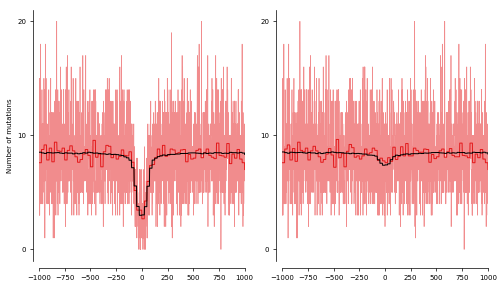

In [29]:
size = 25

listt = ['SYNONYMOUS_healthy', 'NON_SYNONYMOUS_healthy']    

NROW=1
NCOL=2

axs = []

fig = plt.figure(figsize=(7,4))

for row in range(0, NROW):
    for col in range(0, NCOL):
        axs.append(plt.subplot2grid((NROW, NCOL), (row, col)))

cnt=0
for ele in listt:
    plot_HD_BINNED(ele, axs[cnt], cnt, size)
    cnt+=1
    
    
plt.tight_layout()
plt.savefig(path.join('figures', 'selection_test_BINNED_healthy.svg'), bbox_inches='tight')
plt.show()

## Load autism data

In [30]:
## Get mutations
mutations_file = mutations_folder + 'germinal_autism.bed.gz'
mutations_df = pd.read_csv(mutations_file, sep="\t", header=None)
mutations_df.columns = ['chr', 'start', 'end', 'ref', 'alt', 'sample', 'type', 'class', 'ID']
mutations_df = mutations_df[['chr', 'start', 'end', 'ref', 'alt', 'sample', 'type', 'ID']]
mutations_df = mutations_df[mutations_df['type'] == 'subs']

signatures_file = 'results/3mer_signatures_autism.txt'

## Get signatures
all_signatures = pd.read_csv(signatures_file, sep='\t')
probability_name = 'Probability_' + tumor_type
sub_signatures_df = all_signatures[['mutation', probability_name]]
signatures_dict = sub_signatures_df.set_index('mutation').T.to_dict()

## Get consequence tabix file
tb_consequence_type = tabix.open(consequence_type_file)

## Get the consequence rank info and classify separate syn from other types of non-syn (missense, non-sense,...)
consequence_rank_info = pd.read_csv(consequence_ranking_file, delimiter='\t')
consequence_rank_info['TYPE'] = consequence_rank_info.apply(lambda x:synonymous_or_not(x) ,1)
consequence_rank_info = consequence_rank_info[['CONSEQUENCE', 'TYPE']]
consequence_rank_dict = dict(zip(consequence_rank_info['CONSEQUENCE'], consequence_rank_info['TYPE']))

## Middle-Exon centered analysis, synonymous profile

Mutation probabilities were computed genome-wide using the full dataset of germline mutations. Observed and expected values were computed with the method described in the **Exon-centered and intron-centered mutational analyses** section at Frigola et al. However, we do not consider non-synonymous mutations at the exonic positions for the observed and the expected sum of probabilities.

In [31]:
middle_distance_threshold = 1000

include = 'synonymous'

exons_centered_results = obs_exp_muts_excluding(mutations_df, exons_coords_df, signatures_dict, tumor_type, 
                            middle_distance_threshold, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv(path.join('results', "exons_centered_SYNONYMOUS_autism.tsv"), sep="\t", header=True,
                            index=False)

The total amount of mutations at the middle exon-centered sequences is 17721
The total amount of mutations at the exonic sequences are 1688
The category splice_region_variant is found 24 times.
The category splice_donor_variant is found 2 times.
The category None is found 7 times.
The category 5 is found 2 times.
The category intron_variant is found 1 times.
The category missense_variant is found 1147 times.
The category upstream_gene_variant is found 3 times.
The category stop_gained is found 87 times.
The category synonymous_variant is found 411 times.
The category downstream_gene_variant is found 2 times.
The category initiator_codon_variant is found 2 times.


## Middle-Exon centered analysis, non-synonymous profile

Mutation probabilities were computed genome-wide using the full dataset of germline mutations. Observed and expected values were computed with the method described in the **Exon-centered and intron-centered mutational analyses** section at Frigola et al. However, we do not consider synonymous mutations at the exonic positions for the observed and the expected sum of probabilities.

In [32]:
middle_distance_threshold = 1000

include = 'non_synonymous'

exons_centered_results = obs_exp_muts_excluding(mutations_df, exons_coords_df, signatures_dict, tumor_type,
                            middle_distance_threshold, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv(path.join('results', "exons_centered_NON_SYNONYMOUS_autism.tsv"), sep="\t", header=True,
                            index=False)

The total amount of mutations at the middle exon-centered sequences is 17721
The total amount of mutations at the exonic sequences are 1688
The category splice_region_variant is found 24 times.
The category splice_donor_variant is found 2 times.
The category None is found 7 times.
The category 5 is found 2 times.
The category intron_variant is found 1 times.
The category missense_variant is found 1147 times.
The category upstream_gene_variant is found 3 times.
The category stop_gained is found 87 times.
The category synonymous_variant is found 411 times.
The category downstream_gene_variant is found 2 times.
The category initiator_codon_variant is found 2 times.


### Plot results

Polynomial fit approach.

/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: The fit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:17: RankWarning: The fit may be poorly conditioned
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


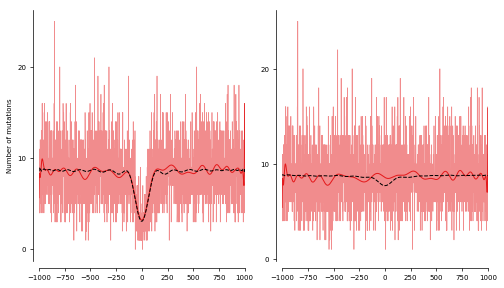

In [33]:
listt = ['SYNONYMOUS_autism', 'NON_SYNONYMOUS_autism']    

NROW=1
NCOL=2

axs = []

fig = plt.figure(figsize=(7,4))

for row in range(0, NROW):
    for col in range(0, NCOL):
        axs.append(plt.subplot2grid((NROW, NCOL), (row, col)))

cnt=0
for ele in listt:
    plot_HD(ele, axs[cnt], cnt)
    cnt+=1
    
    
plt.tight_layout()
plt.savefig(path.join('figures', 'selection_test_autism.svg'), bbox_inches='tight')
plt.show()

### Plot results

Binned average approach. Bin size is 25.

/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


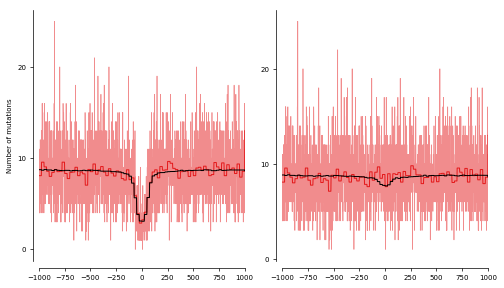

In [34]:
size = 25

listt = ['SYNONYMOUS_autism', 'NON_SYNONYMOUS_autism']    

NROW=1
NCOL=2

axs = []

fig = plt.figure(figsize=(7,4))

for row in range(0, NROW):
    for col in range(0, NCOL):
        axs.append(plt.subplot2grid((NROW, NCOL), (row, col)))

cnt=0
for ele in listt:
    plot_HD_BINNED(ele, axs[cnt], cnt, size)
    cnt+=1
    
    
plt.tight_layout()
plt.savefig(path.join('figures', 'selection_test_BINNED_autism.svg'), bbox_inches='tight')
plt.show()

## General plot

Binned average approach. Bin size is 25.

/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


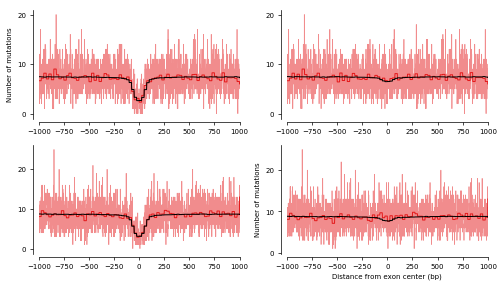

In [35]:
size = 25

listt = ['SYNONYMOUS_sample', 'NON_SYNONYMOUS_sample', 'SYNONYMOUS_autism', 'NON_SYNONYMOUS_autism']    

NROW=2
NCOL=2

axs = []

fig = plt.figure(figsize=(7,4))

for row in range(0, NROW):
    for col in range(0, NCOL):
        axs.append(plt.subplot2grid((NROW, NCOL), (row, col)))

cnt=0
for ele in listt:
    plot_HD_BINNED(ele, axs[cnt], cnt, size)
    cnt+=1
    
    
plt.tight_layout()
plt.savefig(path.join('figures', 'selection_test_BINNED_general.svg'), bbox_inches='tight')
plt.show()